In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [ ]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/22_10_10')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad

opts, args = getopt.gnu_getopt(sys.argv[1:], 't:d:f:n', ['model_type=', 'data=', 'file_path=', 'number='])
model_type = 'basic'
data = 'MDS'
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/split_cluster/test'
number = 4

RNA_data = sc.read_h5ad('/data/cabins/chenshengquan/scglue/Ma-2020-RNA.h5ad')
ATAC_data = sc.read_h5ad('/data/cabins/chenshengquan/scglue/Ma-2020-ATAC.h5ad')

if model_type == 'multiVI_amplification':
    pass

############################################################
# Part 1 data processing
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    output_path=file_path
    )
ATAC_data = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    output_path=file_path
)


############################################################
# Part 2 split datasets
from split_datasets import *
id_list = batch_split_dataset(RNA_data, ATAC_data)
train_id, validation_id, test_id = id_list[int(number) - 1]
train_id_r = train_id.copy()
train_id_a = train_id.copy()
validation_id_r = validation_id.copy()
validation_id_a = validation_id.copy()
test_id_r = test_id.copy()
test_id_a = test_id.copy()

############################################################
# Part 3 calculate chrom list
if data == 'BMMC':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.gene_id.index)):
        temp = ATAC_data.var.gene_id.index[i].split('-')[0]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1
    
elif data == 'MB':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.peak)):
        temp = ATAC_data.var.peak[i].split('_')[0]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1
    
elif data == 'CL':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.chrom)):
        temp = ATAC_data.var.chrom[i]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1
    
elif data == 'MCC':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.chrom)):
        temp = ATAC_data.var.chrom[i]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1
    
elif data == 'MK':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.peak)):
        temp = ATAC_data.var.peak[i].split('_')[0]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1

elif data == 'MDS':
    
    chrom_list = [0 for i in range(20)]
    for i in range(len(ATAC_data.var.chrom)):
        temp = ATAC_data.var.chrom[i]
        if temp[3:] == 'X':
            chrom_list[19] += 1
        else:
            chrom_list[int(temp[3:]) - 1] += 1
    peaks_idx = [[] for i in range(len(chrom_list))]
    for i in range(len(ATAC_data.var.chrom)):
        temp = ATAC_data.var.chrom[i]
        if temp[3:] == 'X':
            peaks_idx[19].append(i)
        else:
            peaks_idx[int(temp[3:]) - 1].append(i)
    peaks_idx_temp = []
    for i in range(len(peaks_idx)):
        peaks_idx_temp.extend(peaks_idx[i])
        
    ATAC_data.X = ATAC_data.X[:, peaks_idx_temp]
    ATAC_data.var = ATAC_data.var.iloc[peaks_idx_temp, :]    

elif data == 'PBMC':
    
    chrom_list = []
    last_one = ''
    for i in range(len(ATAC_data.var.chrom)):
        temp = ATAC_data.var.chrom[i]
        if temp[0 : 3] == 'chr':
            if not temp == last_one:
                chrom_list.append(1)
                last_one = temp
            else:
                chrom_list[-1] += 1
        else:
            chrom_list[-1] += 1


from train_model import Model
import torch
import torch.nn as nn

RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ATAC_input_dim = ATAC_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

train_id, validation_id, test_id = id_list[int(number) - 1]

############################################################
# Part 4 construct model
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    output_path = file_path,
    RNA_data = RNA_data,
    ATAC_data = ATAC_data
)

1
2
3


ma with batch train 3

In [ ]:
import os
import random
import time
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from relation_evaluation import *
from data_processing import *

In [ ]:
RNA_data = RNA_data
ATAC_data = ATAC_data
test_id_r = test_id_r
test_id_a = test_id_a
model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/batch_train/multiVI_amp/"+str(data)+"/"+str(number)
load_model = True
output_path = file_path
test_evaluate = False
test_cluster = True
test_umap = True
output_data = False

if load_model:
    model.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
    model.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
    model.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
    model.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
    model.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

""" load data """
RNA_input_dim = model.RNA_data.shape[1]
ATAC_input_dim = model.ATAC_data.shape[1]

model.R_test_dataset = Single_omics_dataset(model.RNA_data, test_id_r)
model.A_test_dataset = Single_omics_dataset(model.ATAC_data, test_id_a)
model.R_test_dataloader = DataLoader(model.R_test_dataset, batch_size=100, shuffle=False, num_workers=4)
model.A_test_dataloader = DataLoader(model.A_test_dataset, batch_size=100, shuffle=False, num_workers=4)

model.set_eval()

""" record the predicted data """
A2R_predict = []
R2A_predict = []
A2_predict = []
R2_predict = []
with torch.no_grad():
    with tqdm(total = len(model.A_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('ATAC to RNA predicting...')
        for idx, batch_samples in enumerate(model.A_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            A2 = model.ATAC_encoder(batch_samples)
            A2R, A2A, mu_a, sigma_a = model.translator.test_model(A2, 'ATAC')
            A2R = model.RNA_decoder(A2R)

            A2R_predict.append(A2R.cpu())                       
            A2_predict.append(mu_a.cpu())

            time.sleep(0.01)
            pbar.update(1)

with torch.no_grad():
    with tqdm(total = len(model.R_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model.R_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            R2 = model.RNA_encoder(batch_samples)
            R2R, R2A, mu_r, sigma_r = model.translator.test_model(R2, 'RNA')
            R2A = model.ATAC_decoder(R2A)

            R2A_predict.append(R2A.cpu())                       
            R2_predict.append(mu_r.cpu())

            time.sleep(0.01)
            pbar.update(1)

A2R_predict = tensor2adata(A2R_predict)
A2R_predict.obs = RNA_data.obs.iloc[test_id_r, :]
A2R_predict.var = RNA_data.var

R2A_predict = tensor2adata(R2A_predict)
R2A_predict.obs = ATAC_data.obs.iloc[test_id_a, :]
R2A_predict.var = ATAC_data.var

# our a2r

In [ ]:
sc.pp.pca(A2R_predict)
sc.pp.neighbors(A2R_predict)
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)

In [ ]:
fig = sc.pl.tsne(A2R_predict, color='leiden', title='Leiden', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly-C_A2R_leiden.pdf", dpi=300, bbox_inches='tight')

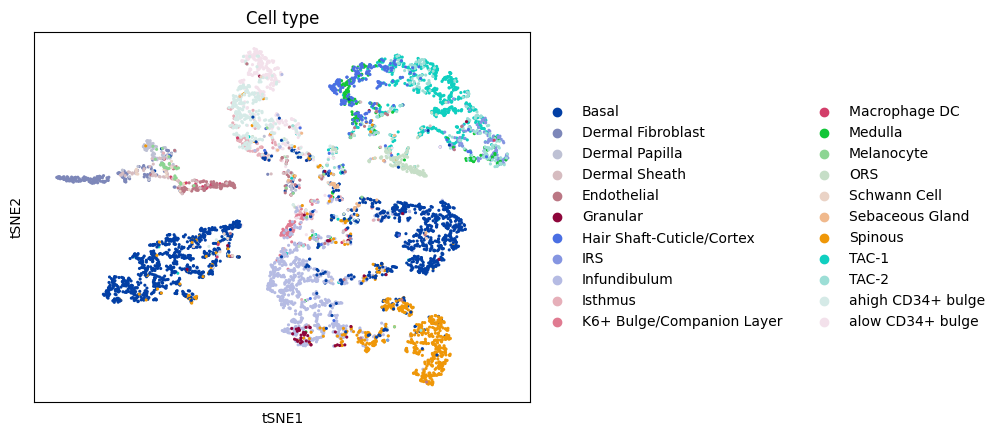

In [8]:
fig = sc.pl.tsne(A2R_predict, color='cell_type', title='Cell type', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly-C_A2R_type.pdf", dpi=300, bbox_inches='tight')

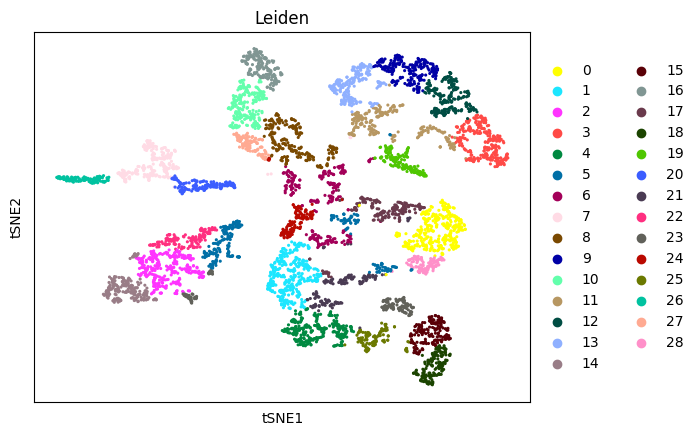

In [8]:
fig = sc.pl.tsne(A2R_predict, color='leiden', title='Leiden', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly_A2R_leiden.pdf", dpi=300, bbox_inches='tight')

In [7]:
import anndata as ad
R_origin_test = ad.AnnData(X=RNA_data.X[test_id_r, :])
R_origin_test.obs = RNA_data.obs.iloc[test_id_r, :]
R_origin_test.var = RNA_data.var

In [8]:
sc.pp.pca(R_origin_test)
sc.pp.neighbors(R_origin_test)
sc.tl.tsne(R_origin_test)
sc.tl.leiden(R_origin_test)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


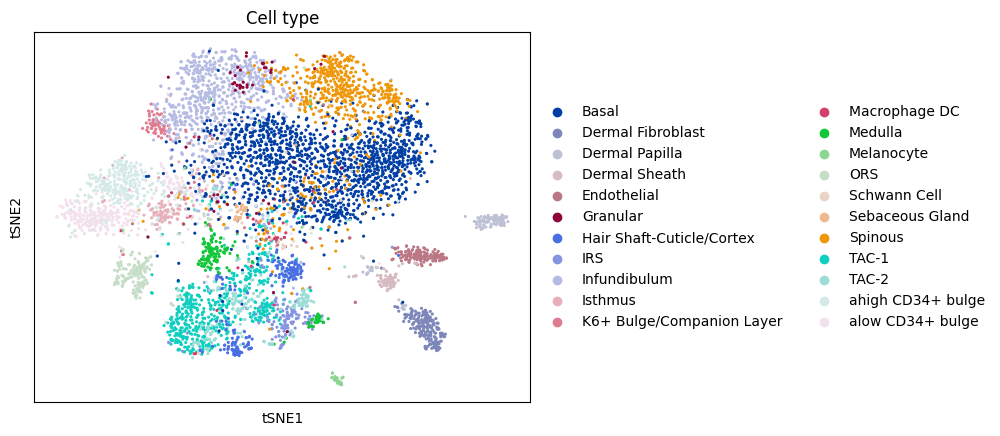

In [12]:
fig =sc.pl.tsne(R_origin_test, color='cell_type', title='Cell type', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e_raw_RNA_type.pdf", dpi=300, bbox_inches='tight')

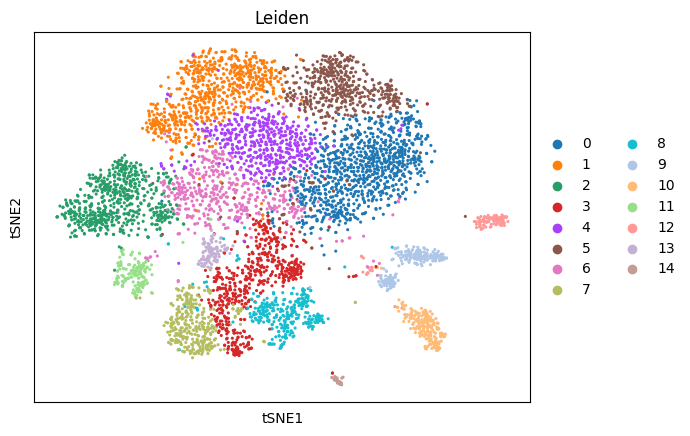

In [13]:
fig = sc.pl.tsne(R_origin_test, color='leiden', title='Leiden', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e_raw_RNA_leiden.pdf", dpi=300, bbox_inches='tight')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


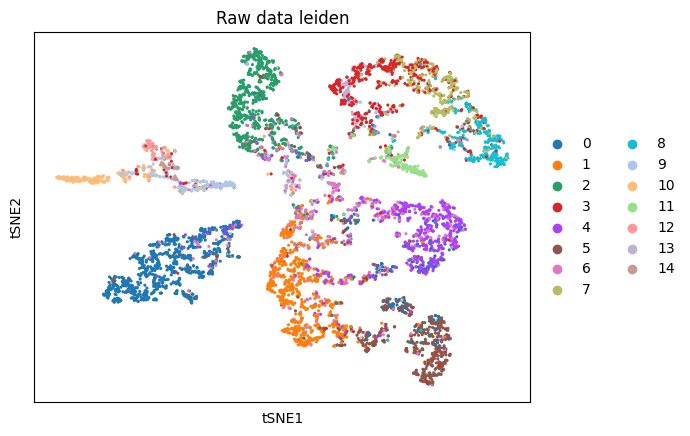

In [14]:
A2R_predict.obs['origin_leiden'] = R_origin_test.obs.leiden
fig = sc.pl.tsne(A2R_predict, color='origin_leiden', title='Raw data leiden', return_fig=True)
fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly-C_A2R_raw_leiden.pdf", dpi=300, bbox_inches='tight')

In [9]:
group1 = ['14', '2', '22']
group2 = ['0', '17', '28', '5']
A2R_predict.obs['intergrate_leiden'] = pd.Series(['0' for i in range(len(A2R_predict.obs.leiden))])
for i in range(len(A2R_predict.obs.leiden)):
    if str(A2R_predict.obs.leiden[i]) in group1:
        A2R_predict.obs.intergrate_leiden[i] = 'Basal 1'
    elif str(A2R_predict.obs.leiden[i]) in group2:
        A2R_predict.obs.intergrate_leiden[i] = 'Basal 2'
    else:
        A2R_predict.obs.intergrate_leiden[i] = ''

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
group1 = ['0']
group2 = ['4']
R_origin_test.obs['intergrate_leiden'] = pd.Series(['0' for i in range(len(R_origin_test.obs.leiden))])
for i in range(len(R_origin_test.obs.leiden)):
    if str(R_origin_test.obs.leiden[i]) in group1:
        R_origin_test.obs.intergrate_leiden[i] = 'Basal 1'
    elif str(R_origin_test.obs.leiden[i]) in group2:
        R_origin_test.obs.intergrate_leiden[i] = 'Basal 2'
    else:
        R_origin_test.obs.intergrate_leiden[i] = ''

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


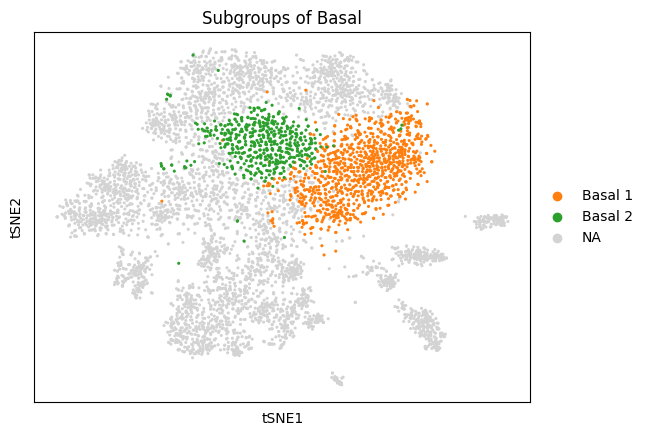

In [11]:
fig = sc.pl.tsne(R_origin_test, color='intergrate_leiden', title='Subgroups of Basal', groups=['Basal 1', 'Basal 2'], return_fig=True)
#fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly-C_raw_RNA_split.pdf", dpi=300, bbox_inches='tight')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


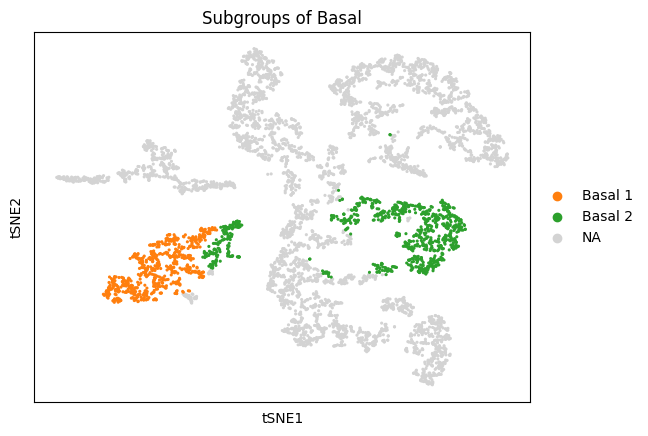

In [12]:
fig = sc.pl.tsne(A2R_predict, color='intergrate_leiden', title='Subgroups of Basal', groups=['Basal 1', 'Basal 2'], return_fig=True)
#fig.savefig("/home/atac2rna/data/atac2rna/butterfly_figure/figure/fig_3_e/fig_3_e_scButterfly-C_A2R_split.pdf", dpi=300, bbox_inches='tight')

In [20]:
import numpy as np
import pandas as pd
stats = np.zeros((3, 3))
A2R = A2R_predict.obs.intergrate_leiden
R = R_origin_test.obs.intergrate_leiden
index_list = ['Basal 1', 'Basal 2', '']
for i in range(len(range(A2R_predict.shape[0]))):
    stats[index_list.index(A2R[i]), index_list.index(R[i])] += 1
stats = pd.DataFrame(stats, index=index_list, columns=index_list)
stats

,Basal 1,Basal 2,
Basal 1,600.0,10.0,25.0
Basal 2,233.0,425.0,238.0
,166.0,106.0,4124.0


In [17]:
a = [0, 1, 2]
a.index(1)

1

In [45]:
group1 = ['0']
group2 = ['4']
R_origin_test.obs['intergrate_leiden'] = pd.Series(['0' for i in range(len(R_origin_test.obs.leiden))])
for i in range(len(R_origin_test.obs.leiden)):
    if str(R_origin_test.obs.leiden[i]) in group1:
        R_origin_test.obs.intergrate_leiden[i] = '1'
    elif str(R_origin_test.obs.leiden[i]) in group2:
        R_origin_test.obs.intergrate_leiden[i] = '2'
    else:
        R_origin_test.obs.intergrate_leiden[i] = '0'

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


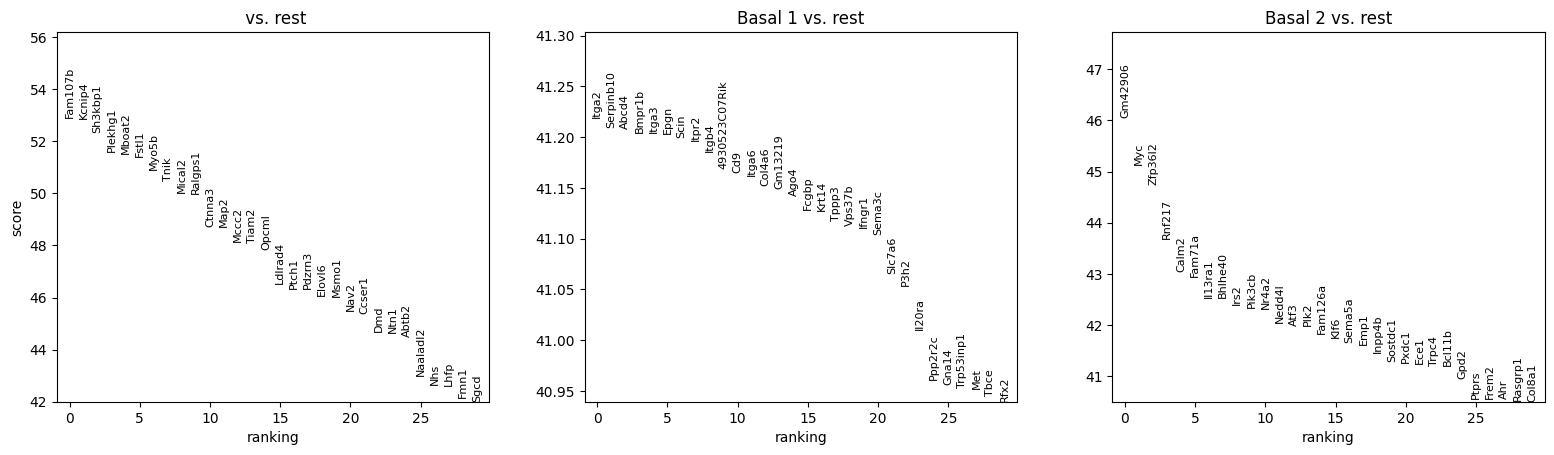

In [46]:
sc.tl.rank_genes_groups(A2R_predict, groupby='intergrate_leiden', method='wilcoxon')
sc.pl.rank_genes_groups(A2R_predict, n_genes=30, gene_symbols='name', sharey=False)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


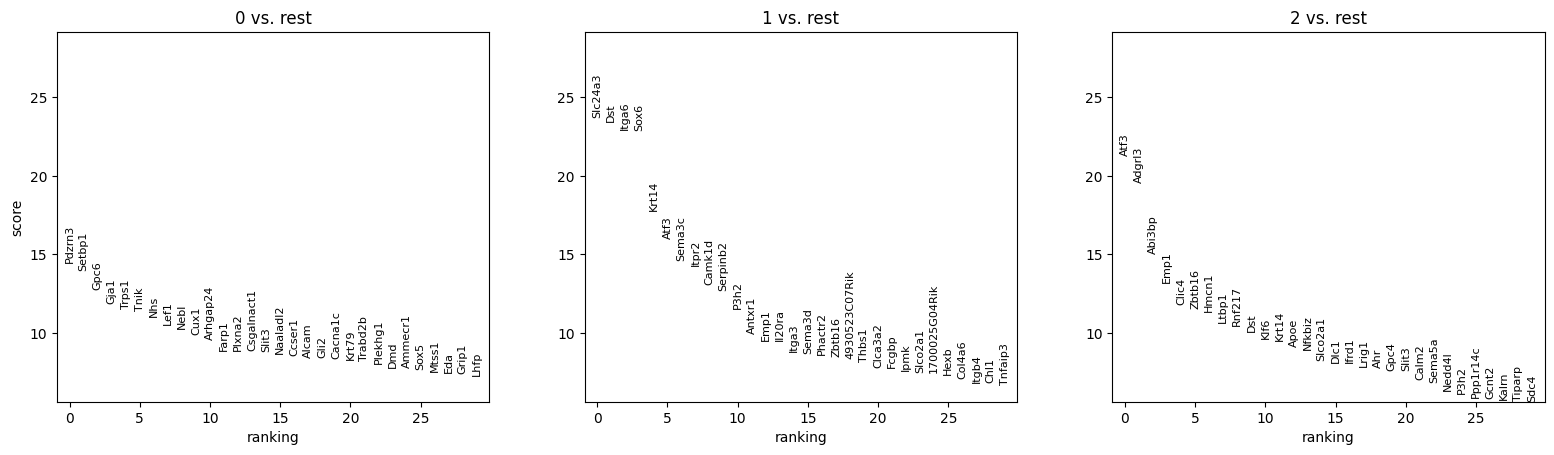

In [47]:
sc.tl.rank_genes_groups(R_origin_test, groupby='intergrate_leiden', method='wilcoxon')
sc.pl.rank_genes_groups(R_origin_test, n_genes=30, gene_symbols='name')

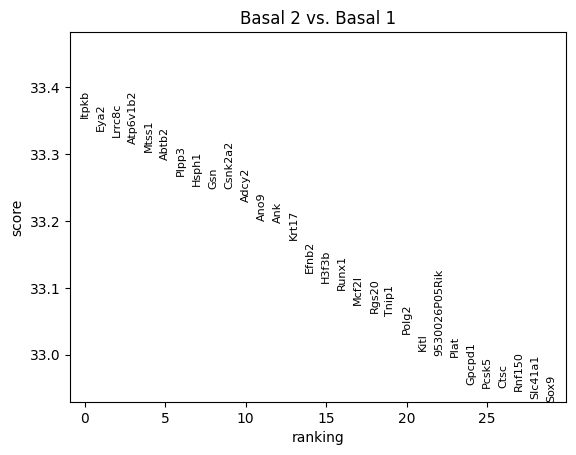

In [48]:
sc.tl.rank_genes_groups(A2R_predict, groupby='intergrate_leiden', method='wilcoxon', reference='Basal 1')
sc.pl.rank_genes_groups(A2R_predict, n_genes=30, gene_symbols='name', sharey=False, groups=['Basal 2'])

In [59]:
temp = list(A2R_predict.uns['rank_genes_groups']['names'])
group_list = [each[1] for each in temp]
i = 0
pred_gene = []
for each in group_list:
    #if not each[0:2] == 'mt':
    print(each)
    pred_gene.append(each)
    i += 1
    if i == 40:
        break

Itpkb
Eya2
Lrrc8c
Atp6v1b2
Mtss1
Abtb2
Plpp3
Hsph1
Gsn
Csnk2a2
Adcy2
Ano9
Ank
Krt17
Efnb2
H3f3b
Runx1
Mcf2l
Rgs20
Tnip1
Polg2
Kitl
9530026P05Rik
Plat
Gpcpd1
Pcsk5
Ctsc
Rnf150
Slc41a1
Sox9
Tiam2
Ammecr1
Skint4
Slc12a2
Slit3
mt-Cytb
Gli2
Gas7
Adamts9
Tle1


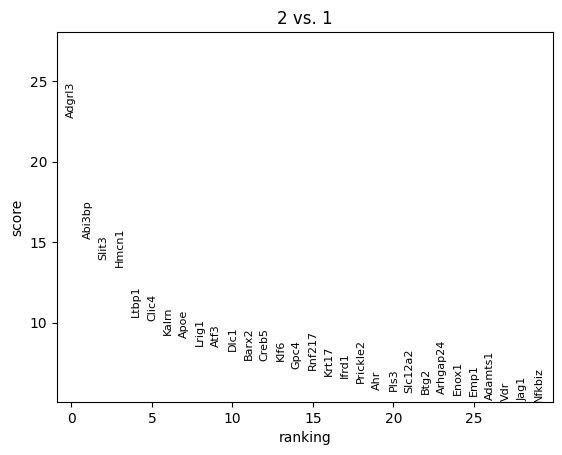

In [50]:
sc.tl.rank_genes_groups(R_origin_test, groupby='intergrate_leiden', method='wilcoxon', reference='1')
sc.pl.rank_genes_groups(R_origin_test, n_genes=30, gene_symbols='name', sharey=False, groups='2')

In [60]:
temp = list(R_origin_test.uns['rank_genes_groups']['names'])
group_list = [R_origin_test.var.name[each[1]] for each in temp]
raw_gene = []
for each in group_list[0:40]:
    raw_gene.append(each)
    print(each)

Adgrl3
Abi3bp
Slit3
Hmcn1
Ltbp1
Clic4
Kalrn
Apoe
Lrig1
Atf3
Dlc1
Barx2
Creb5
Klf6
Gpc4
Rnf217
Krt17
Ifrd1
Prickle2
Ahr
Pls3
Slc12a2
Btg2
Arhgap24
Enox1
Emp1
Adamts1
Vdr
Jag1
Nfkbiz
Atxn7l1
Nebl
Gli3
Efnb2
Fst
Prlr
Calm2
Ythdc1
Gpcpd1
Msra


In [61]:
len(set(pred_gene) & set(raw_gene))

5

In [57]:
raw_1 = []
raw_2 = []
pred_1 = []
pred_2 = []
for i in range(R_origin_test.X.shape[0]):
    if R_origin_test.obs.intergrate_leiden[i] == 'Basal 1':
        raw_1.append(i)
    if R_origin_test.obs.intergrate_leiden[i] == 'Basal 2':
        raw_2.append(i)
    if A2R_predict.obs.intergrate_leiden[i] == 'Basal 1':
        pred_1.append(i)
    if A2R_predict.obs.intergrate_leiden[i] == 'Basal 2':
        pred_2.append(i)

In [58]:
all_data = raw_1.copy()
all_data.extend(raw_2)
all_data.extend(pred_1)
all_data.extend(pred_2)
all_data = list(set(all_data))

In [59]:
temp = pd.DataFrame(index=all_data, columns=['0', '1'])

In [60]:
for each in all_data:
    if each in raw_1 and each in pred_1:
        temp.loc[each, :] = ['raw 1', 'pred 1']
    if each in raw_1 and each in pred_2:
        temp.loc[each, :] = ['raw 1', 'pred 2']
    if each in raw_1 and each not in pred_2 and each not in pred_1:
        temp.loc[each, :] = ['raw 1', 'else']
    if each in raw_2 and each in pred_2:
        temp.loc[each, :] = ['raw 2', 'pred 1']
    if each in raw_2 and each in pred_2:
        temp.loc[each, :] = ['raw 2', 'pred 2']
    if each in raw_2 and each not in pred_2 and each not in pred_1:
        temp.loc[each, :] = ['raw 2', 'else']
    if each in pred_1 and each not in raw_1 and each not in raw_2:
        temp.loc[each, :] = ['pred 1', 'else']
    if each in pred_2 and each not in raw_1 and each not in raw_2:
        temp.loc[each, :] = ['pred 2', 'else']        

In [79]:
import numpy as np
import pandas as pd
import itertools
from chord import Chord
data = list(itertools.chain.from_iterable((i, i[::-1]) for i in temp.values))
matrix = pd.pivot_table(
    pd.DataFrame(data), index=0, columns=1, aggfunc="size", fill_value=0
).values.tolist()
pd.DataFrame(matrix)
names = ['else', 'Prediction Basal 1', 'Prediction Basal 2', 'Raw Basal 1', 'Raw Basal 2']

In [80]:
pd.DataFrame(matrix)

,0,1,2,3,4
0,0,78,206,154,88
1,78,0,0,763,0
2,206,0,0,82,420
3,154,763,82,0,0
4,88,0,420,0,0


In [89]:
from mpl_chord_diagram import chord_diagram

[(0.012789994374512222, -1.0499220999883279, 0.6979341150195069),
 (0.9833982544139365, -0.3680052624835995, 69.48324958123953),
 (0.569405866945757, 0.8822000672680494, 327.16024567280846),
 (-0.8336497325376553, 0.6383792943383234, 412.5563930764936),
 (-0.8253597745635762, -0.6490618171887504, 308.1814628699051)]

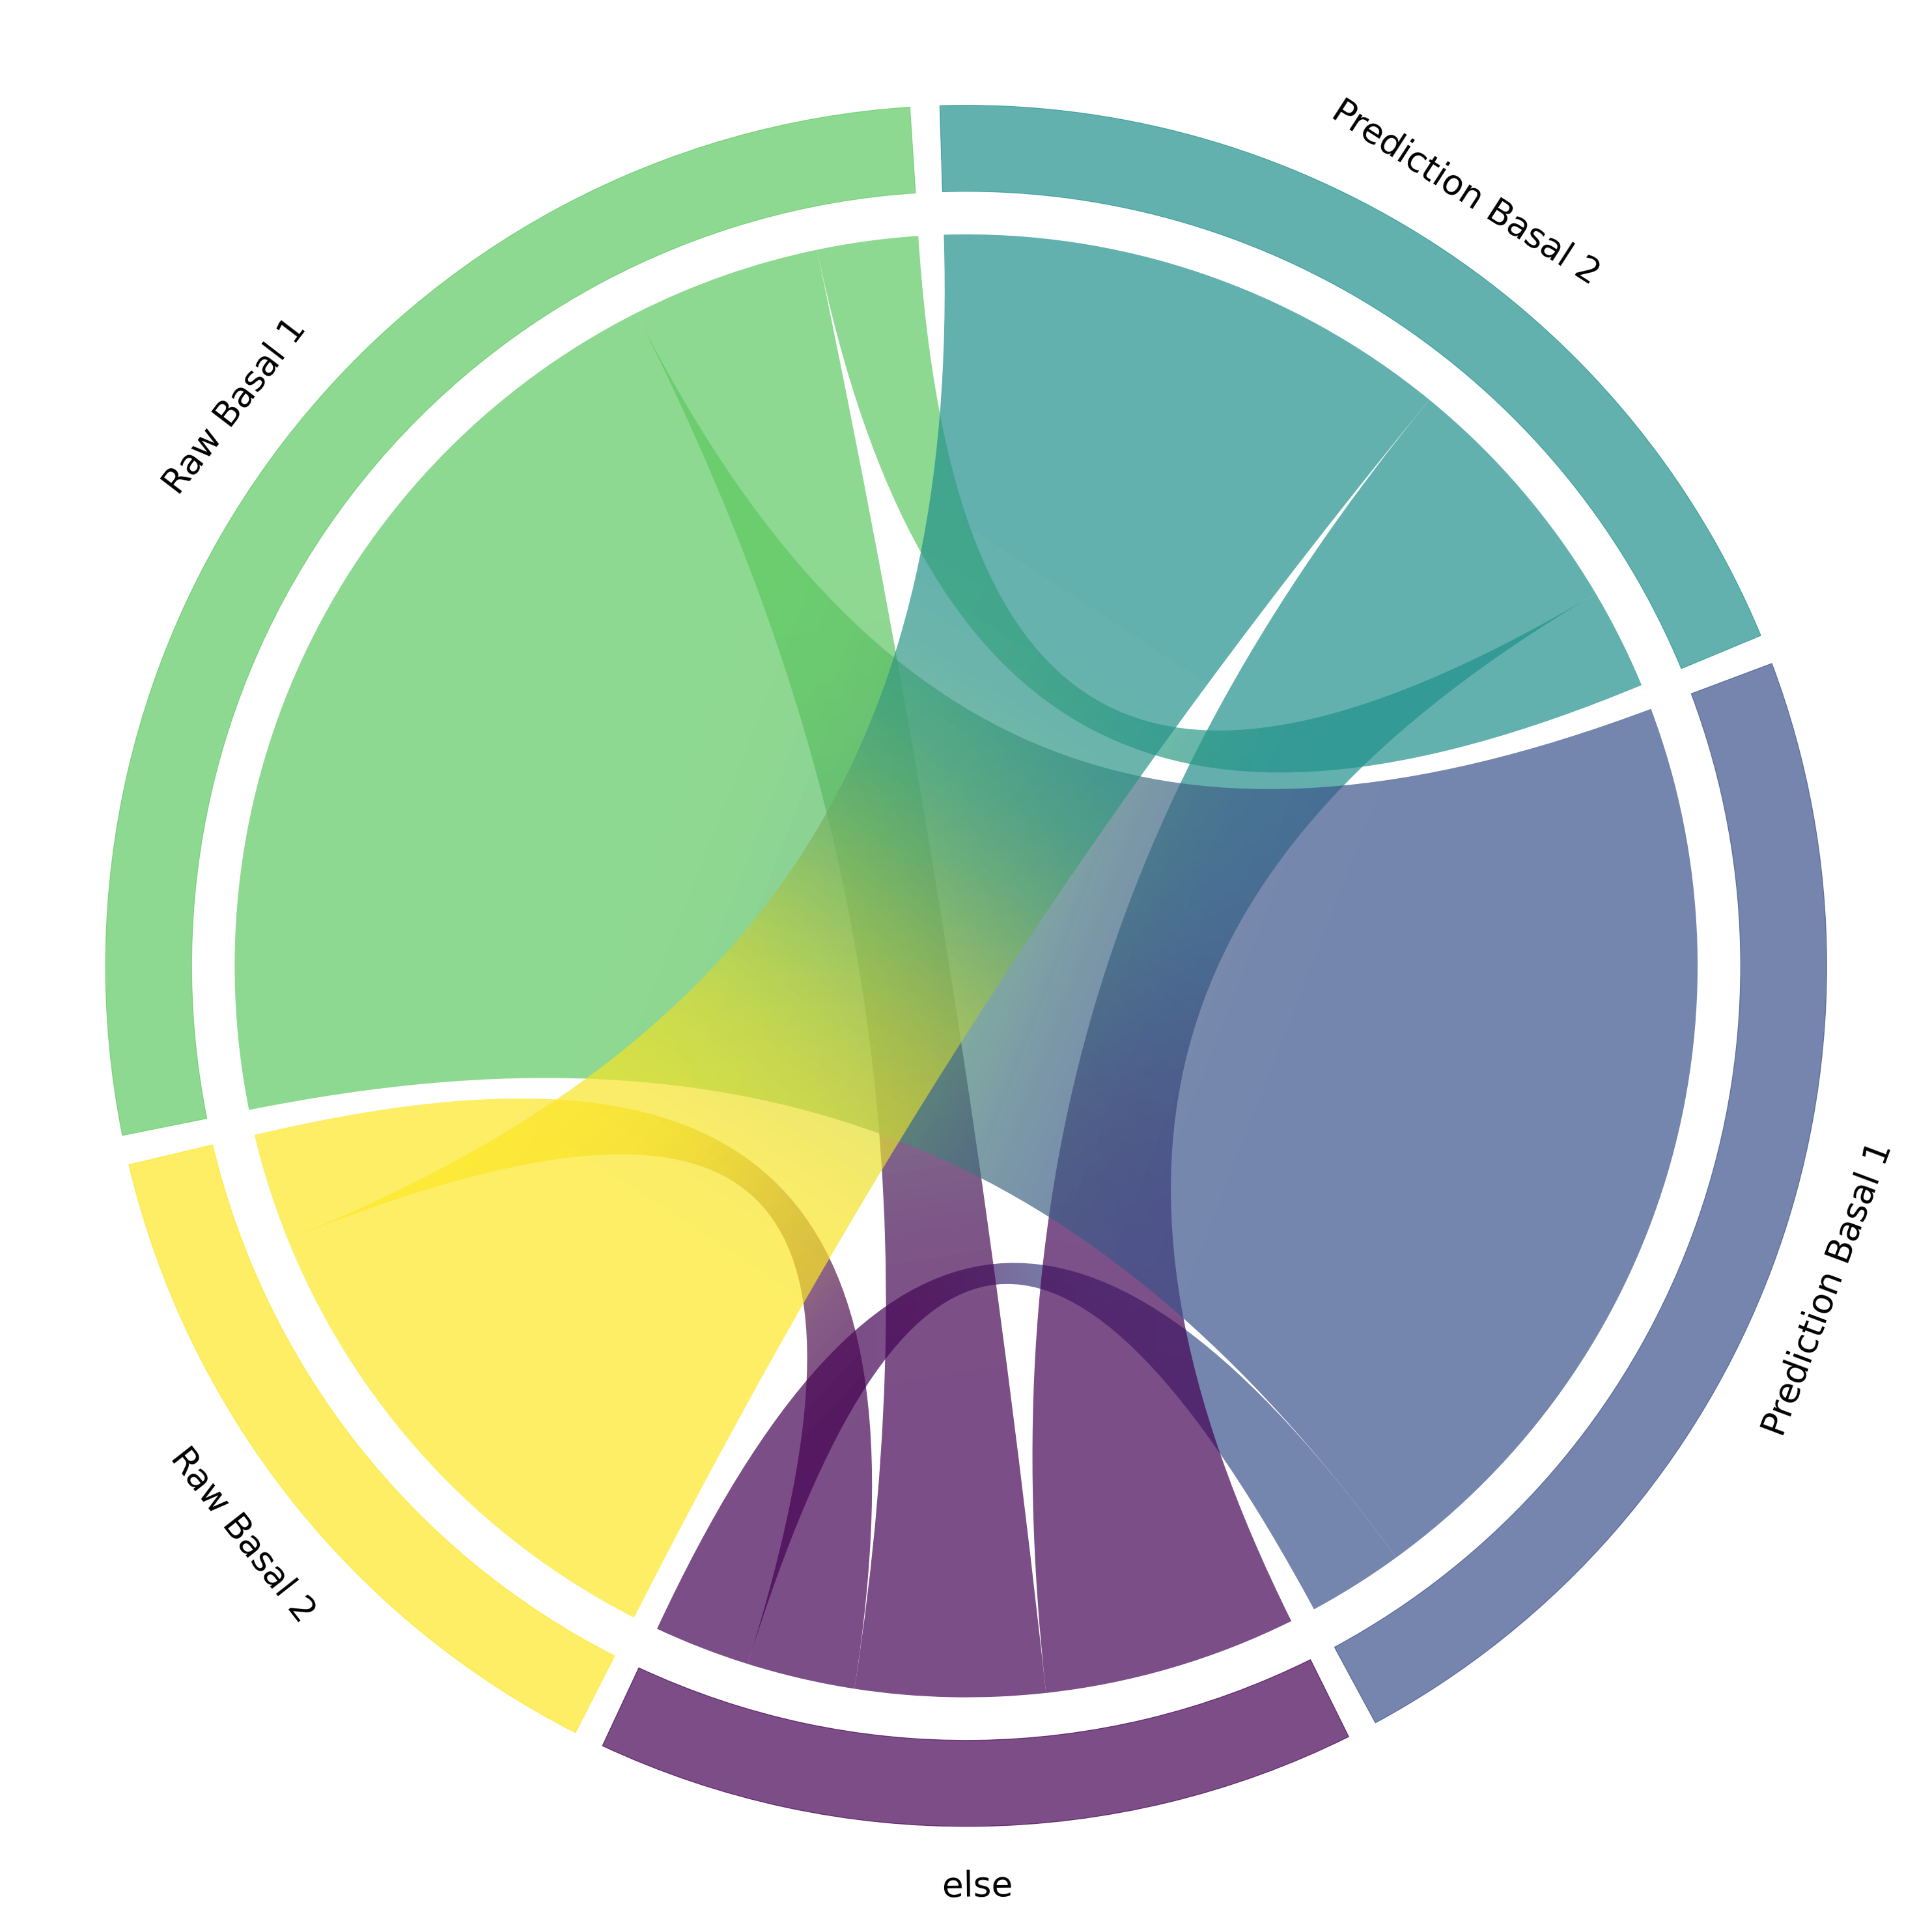

In [98]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
chord_diagram(matrix, names, use_gradient = True, gap=0.05, ax=ax1, start_at=245)